# Semantic textual similarity
## Final Project IHLT - UPC 2022/2023
### Authors : Rob - Edison Bejarano

1. Data

2. What we are doing?
#### Techniques for preprocessing text for similarity comparison

- Stemming: is a process that involves reducing words to their base form, or stem, in order to normalize the text and remove variations in word endings. For example, the words "running," "runs," and "ran" would all be reduced to the stem "run" by a stemming algorithm.


- Lemmatization: is a process that involves reducing words to their base form, or lemma, in order to normalize the text and remove variations in word endings. Unlike stemming, lemmatization takes into account the context of the word in order to determine its lemma, resulting in more accurate and meaningful reductions. For example, the words "running," "runs," and "ran" would all be reduced to the lemma "run" by a lemmatization algorithm.

- Tf-idf weighting: Is a method for assigning a weight to each word in a document based on its relative importance. The weight is calculated by multiplying the term frequency (tf) of the word by the inverse document frequency (idf) of the word across all documents in a corpus. This weighting scheme gives higher weight to words that are more frequent within a document but less frequent across the corpus, making them more important for characterizing the document.

- NES : Function used the Natural Language Toolkit (nltk) to identify named entities in a given sentence. The sentence parameter is the sentence in which named entities should be identified, and the binary parameter determines whether named entities should be grouped together or returned as individual tokens. The function returns a set of the named entities and individual words found in the sentence.


These techniques can be used in combination with each other or with stopwords removal to preprocess text and improve the accuracy of similarity comparison. For example, you could use stemming or lemmatization to normalize the words in the phrases, and then use tf-idf weighting to assign importance to each word based on its frequency within the phrases and across a larger corpus. This would allow you to compare the similarity of the phrases in a more meaningful and accurate way


3. Results

## Install packages

In [ ]:
%pip install -q spacy nltk numpy pandas scikit-learn pyjarowinkler lazypredict


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


# Libraries

In [92]:
import os
import re
import nltk
import spacy
import string
import numpy as np
import pandas as pd

from tqdm import tqdm
from itertools import chain
from functools import partial
from argparse import Namespace
from pyjarowinkler import distance

from nltk.wsd import lesk
from nltk.stem import WordNetLemmatizer
from nltk.metrics import jaccard_distance
from nltk.corpus import stopwords, wordnet

from scipy.stats import pearsonr

from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from typing import List
from lazypredict.Supervised import LazyClassifier

nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('gutenberg')

nltk.download('conll2000')
nltk.download('brown')
nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ejbejaranos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/ejbejaranos/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/ejbejaranos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ejbejaranos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ejbejaranos/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/ejbejaranos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /hom

True

## Download data

In [ ]:
#!curl -o /content/drive/MyDrive/Colab_Notebooks/2.IHLT/final_project/trial.tgz https://gebakx.github.io/ihlt/sts/resources/trial.tgz
#!curl -o /content/drive/MyDrive/Colab_Notebooks/2.IHLT/final_project/train.tgz https://gebakx.github.io/ihlt/sts/resources/train.tgz
#!curl -o /content/drive/MyDrive/Colab_Notebooks/2.IHLT/final_project/test-gold.tgz https://gebakx.github.io/ihlt/sts/resources/test-gold.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2003  100  2003    0     0  47690      0 --:--:-- --:--:-- --:--:-- 47690
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  122k  100  122k    0     0   505k      0 --:--:-- --:--:-- --:--:--  503k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  115k  100  115k    0     0   345k      0 --:--:-- --:--:-- --:--:--  345k


# Bring data

In [15]:
!tar zxvf ../final_project/train.tgz
!tar zxvf ../final_project/trial.tgz
!tar zxvf ../final_project/test-gold.tgz

!rm ../final_project/train.tgz
!rm ../final_project/test-gold.tgz 
!rm ../final_project/trial.tgz


train/
train/00-readme.txt
train/STS.output.MSRpar.txt
train/STS.input.SMTeuroparl.txt
train/STS.input.MSRpar.txt
train/STS.gs.MSRpar.txt
train/STS.input.MSRvid.txt
train/STS.gs.MSRvid.txt
train/correlation.pl
train/STS.gs.SMTeuroparl.txt
trial/
trial/STS.input.txt
trial/00-readme.txt
trial/STS.gs.txt
trial/STS.ouput.txt
test-gold/
test-gold/STS.input.MSRpar.txt
test-gold/STS.gs.MSRpar.txt
test-gold/STS.input.MSRvid.txt
test-gold/STS.gs.MSRvid.txt
test-gold/STS.input.SMTeuroparl.txt
test-gold/STS.gs.SMTeuroparl.txt
test-gold/STS.input.surprise.SMTnews.txt
test-gold/STS.gs.surprise.SMTnews.txt
test-gold/STS.input.surprise.OnWN.txt
test-gold/STS.gs.surprise.OnWN.txt
test-gold/STS.gs.ALL.txt
test-gold/00-readme.txt


# Usesful functions

In [93]:
# ------------------------------ #
# Lesk Function 
# ------------------------------ #
def apply_jaccard_lesk(sentence1: str, sentence2: str):

  # Apply lesk to sentence 1
  synset1 = [ lesk(sentence1, word) for word in sentence1 ]
  synset1 = { word for word in synset1 if word is not None }

  # Apply lesk to sentence 1
  synset2 = [ lesk(sentence2, word) for word in sentence2 ]
  synset2 = { word for word in synset2 if word is not None }

  # Calculate distance
  distance = jaccard_distance(synset1, synset2)

  return distance


# ------------------------------ #
# Jaccard similarity Function
# ------------------------------ #
def jaccard_similarity(s1: List[str], s2: List[str]):
    s1 = set(s1)
    s2 = set(s2)
    intersection = len(s1.intersection(s2))
    union = len(s1) + len(s2) - intersection
    return float(intersection) / float(union)


# ------------------------------ #
# Jaccard Similarity List
# ------------------------------ #
def jaccard_similarity_list(s1: List[List[str]], s2: List[List[str]]):
    return np.array(list(map(jaccard_similarity, s1, s2)))

# ------------------------------ #
# Jarowinkler Similarity
# ------------------------------ #   
def calculateJarowinklerSimilarity(dataframe, column1, column2):

  aux = []
  for row in dataframe.itertuples():
    
    # Longest one selected
    if len(row[column1]) >= len(row[column2]):
      sentence1 = row[column1]
      sentence2 = row[column2]
    else:
      sentence1 = row[column2]
      sentence2 = row[column1]

    similarities_array = []
    for word1 in sentence1:
      max = 0

      for word2 in sentence2:
        similarity = distance.get_jaro_distance(str(word1), str(word2), winkler=True, scaling=0.1)
           
        if max < similarity:
          max = similarity
        
      similarities_array.append(max)

    aux.append(np.array(similarities_array).mean())

  return aux

  
   

In [97]:
# ------------------------------ #
#         Get Wordnet POS
# ------------------------------ #
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"NN": "n",
                "NNS": "n",
                "NNP": "n",
                "NNPS": "n",
                "VB": "v",
                "VBD": "v",
                "VBG": "v",
                "VBN": "v",
                "VBP": "v",
                "VBZ": "v",
                "RB": "r",
                "RBR": "r",
                "RBS": "r",
                "JJ": "a",
                "JJR": "a",
                "JJS": "a",}
        
    return tag_dict.get(tag, wordnet.NOUN)


# ------------------------------ #
#   Function to tokenize
# ------------------------------ #
def tokenize_column(column):
  #put in lowercase
  tokenized = [nltk.word_tokenize(sentence) for sentence in column]
  #Lowercase the tokens
  tokenized = [ [ word.lower() for word in sentence ] for sentence in tokenized ]
  return tokenized



#--------------------------------------------#
#  Function to NES
#--------------------------------------------#
def NES(sentence: str, binary: bool):
  x = nltk.pos_tag(nltk.word_tokenize(sentence))
  res = nltk.ne_chunk(x, binary=binary)
  necs_and_words = set()
  for chunk in res:
        if hasattr(chunk, 'label'):
            # Add NE
            token = ' '.join(term[0] for term in chunk)
            necs_and_words.add(token)
        else:
            token = chunk[0]
            if token.isalnum():
                necs_and_words.add(token.lower())
  return necs_and_words 
 #--------------------------------------------#
 # Function to get entities from a column
 # -------------------------------------------# 
def get_entities_new(column):
    entities = []
    for sentence in column:
        entities.append(NES(sentence, False))
    return entities



# ------------------------------ #
# Lemmatization text process
# ------------------------------ #
lemmatizer = WordNetLemmatizer()
# ------------------------------ #
#   Function to lemmatize
# ------------------------------ #
def lemmatize(column):
  
  lemmas = []

  for sentence in tqdm(column):
    sentence_lemmas = []
    for word in nltk.word_tokenize(sentence):
      sentence_lemmas.append(lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())))
    lemmas.append(sentence_lemmas)

  return lemmas


# ------------------------------ #
#   Stopwords initialization
# ------------------------------ #
stopwords = nltk.corpus.stopwords.words("english")
stopwords[:10]
stopwords += string.punctuation
stopwords += ['.', ',', ';', '."']
# ------------------------------ #
#   Function to remove stopwords
# ------------------------------ #
def remove_stopwords(column):
  tokenized = [nltk.word_tokenize(sentence) for sentence in column]
  #Lowercase the tokens
  tokenized = [ [ word.lower() for word in sentence ] for sentence in tokenized ]
  return [ [ word for word in sentence if word not in stopwords ] for sentence in tokenized ]


# ------------------------------ #
#   Function to synonimize
# ------------------------------ #
def synonimize_column(column):
  #put in lowercase
  tokenized = [nltk.word_tokenize(sentence) for sentence in column]
  #Lowercase the tokens
  tokenized = [ [ word.lower() for word in sentence ] for sentence in tokenized ]
  #Synonimize
  synonimized = [ [ word for word in sentence if word not in stopwords ] for sentence in tokenized ]

  return synonimized
  

In [95]:
# Functions of preprocessing
def read_data(text_datas: list[str], gs_datas: list[str]):
  all_df_text = []
  for text_data, gs_data in zip(text_datas, gs_datas):
    df_text = pd.read_csv(text_data, sep=r'\t', engine='python', header=None)
    df_text.columns = ["text1", "text2"]
    df_text['gs'] = pd.read_csv(gs_data, sep='\t', header=None)
    all_df_text.append(df_text.dropna())
  return pd.concat(all_df_text)

def get_dataset(path: str) -> pd.DataFrame:
  files = sorted(os.listdir(path))
  input_files = [ os.path.join(path, file) for file in files if 'input' in file ]
  gs_files = [ os.path.join(path, file) for file in files if 'gs' in file ]
  df = read_data(input_files, gs_files)
  return df

# Pre-processing

### Data information
- trial : includes the definition of the scores, a sample of 5 sentence pairs and the input and output formats. It is not needed, but it is useful for prototyping.

- train : training data from paraphrasing data sets, input and output formats.

- test : test data from paraphrasing data sets.

In [3]:
train_path = '../final_project/train'
trial_path = '../final_project/trial'
test_path  = '../final_project/test-gold'

# **Similarities**

In [83]:

train_dataset_pruebas = get_dataset(train_path)
test_dataset_pruebas = get_dataset(test_path)
df = train_dataset_pruebas


In [98]:
# Tokenization features
tokenized_text1 = tokenize_column(df['text1'])
tokenized_text2 = tokenize_column(df['text2'])

# Lemmatization features
lemmatize_text1 = lemmatize(df['text1'])
lemmatize_text2 = lemmatize(df['text2'])


#Use stopwords function to remove stopwords
stopwords_text1 = remove_stopwords(df['text1'])
stopwords_text2 = remove_stopwords(df['text2'])



# Synonyms features
synonyms_text1 = []
synonyms_text2 = []
# Use sysnstesizer to get synonyms
for i in tqdm(range(len(tokenized_text1))):
    synonyms_text1.append([syn for w in tokenized_text1[i] for syn in wordnet.synsets(w)])
    synonyms_text2.append([syn for w in tokenized_text2[i] for syn in wordnet.synsets(w)])


# Synonyms features another way
synonimized_text1_new = synonimize_column(df['text1'])
synonimized_text2_new = synonimize_column(df['text2'])


# NES features
NES_column_text1 = get_entities_new(df['text1'])
NES_column_text2 = get_entities_new(df['text2'])

100%|██████████| 2234/2234 [00:00<00:00, 2591.00it/s]


In [62]:
# Jaccard similarity features
jaccard_similarity_tokenized = jaccard_similarity_list(tokenized_text1, tokenized_text2)
jaccard_similarity_synonyms_new = jaccard_similarity_list(synonimized_text1_new, synonimized_text2_new)
jaccard_similarity_NES = jaccard_similarity_list(NES_column_text1, NES_column_text2)

jaccard_similarity_lemmatize = jaccard_similarity_list(lemmatize_text1, lemmatize_text2)
jaccard_similarity_stopwords = jaccard_similarity_list(stopwords_text1, stopwords_text2)
jaccard_similarity_synonyms = jaccard_similarity_list(synonyms_text1, synonyms_text2)


print("Jaccard similarity tokenized: ", jaccard_similarity_tokenized[:3])
print("Jaccard similarity lemmatize: ", jaccard_similarity_lemmatize[:3])
print("Jaccard similarity stopwords: ", jaccard_similarity_stopwords[:3])
print("Jaccard similarity synonyms: ", jaccard_similarity_synonyms[:3])
print("Jaccard similarity synonyms new: ", jaccard_similarity_synonyms_new[:3])


Jaccard similarity tokenized:  [0.5483871  0.42105263 0.34782609]
Jaccard similarity lemmatize:  [0.5483871  0.42105263 0.34782609]
Jaccard similarity stopwords:  [0.47368421 0.46153846 0.33333333]
Jaccard similarity synonyms:  [0.67680608 0.30172414 0.38562092]
Jaccard similarity synonyms new:  [0.47368421 0.46153846 0.33333333]


In [53]:
#put everythiong in a dataframe
df['tokenized_text1'] = tokenized_text1
df['tokenized_text2'] = tokenized_text2
df['lemmatize_text1'] = lemmatize_text1
df['lemmatize_text2'] = lemmatize_text2
df['stopwords_text1'] = stopwords_text1
df['stopwords_text2'] = stopwords_text2
df['synonyms_text1'] = synonyms_text1
df['synonyms_text2'] = synonyms_text2
df.head()

,text1,text2,gs,tokenized_text1,tokenized_text2,lemmatize_text1,lemmatize_text2,stopwords_text1,stopwords_text2,synonyms_text1,synonyms_text2
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,"[But, other, sources, close, to, the, sale, sa...","[But, other, sources, close, to, the, sale, sa...","[but, other, source, close, to, the, sale, say...","[but, other, source, close, to, the, sale, say...","[sources, close, sale, said, vivendi, keeping,...","[sources, close, sale, said, vivendi, keeping,...","[Synset('merely.r.01'), Synset('other.a.01'), ...","[Synset('merely.r.01'), Synset('other.a.01'), ..."
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,"[Micron, has, declared, its, first, quarterly,...","[Micron, has, declared, its, first, quarterly,...","[micron, have, declare, it, first, quarterly, ...","[micron, 's, number, also, marked, the, first,...","[micron, declared, first, quarterly, profit, t...","[micron, 's, numbers, also, marked, first, qua...","[Synset('micron.n.01'), Synset('hour_angle.n.0...","[Synset('micron.n.01'), Synset('hour_angle.n.0..."
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.80,"[The, fines, are, part, of, failed, Republican...","[The, fines, are, part, of, failed, Republican...","[the, fine, be, part, of, fail, republican, ef...","[perry, say, he, back, the, senate, 's, effort...","[fines, part, failed, republican, efforts, for...","[perry, said, backs, senate, 's, efforts, incl...","[Synset('fine.n.01'), Synset('ticket.v.01'), S...","[Synset('fine.n.01'), Synset('ticket.v.01'), S..."
3,"The American Anglican Council, which represent...","The American Anglican Council, which represent...",3.40,"[The, American, Anglican, Council, ,, which, r...","[The, American, Anglican, Council, ,, which, r...","[the, american, anglican, council, ,, which, r...","[the, american, anglican, council, ,, which, r...","[american, anglican, council, represents, epis...","[american, anglican, council, represents, epis...","[Synset('american.n.01'), Synset('american_eng...","[Synset('american.n.01'), Synset('american_eng..."
4,The tech-loaded Nasdaq composite rose 20.96 po...,The technology-laced Nasdaq Composite Index <....,2.40,"[The, tech-loaded, Nasdaq, composite, rose, 20...","[The, tech-loaded, Nasdaq, composite, rose, 20...","[the, tech-loaded, nasdaq, composite, rise, 20...","[the, technology-laced, nasdaq, composite, ind...","[tech-loaded, nasdaq, composite, rose, 20.96, ...","[technology-laced, nasdaq, composite, index, ....",[Synset('national_association_of_securities_de...,[Synset('national_association_of_securities_de...


In [100]:
def get_features(df: pd.DataFrame):

    #--------------------------------------------#
    # 0. NLTK Words features
    #--------------------------------------------#
    #print("NLTK Words features")
    
    #nltk_words_text1 = []
    #nltk_words_text2 = []

    #--------------------------------------------#
    # 1. Tokenize features
    #--------------------------------------------#    
    tokenized_text1 = tokenize_column(df['text1'])
    tokenized_text2 = tokenize_column(df['text2'])

    #--------------------------------------------#
    # 2. Lemmatize features
    #--------------------------------------------#
    lemmatize_text1 = lemmatize(df['text1'])
    lemmatize_text2 = lemmatize(df['text2'])


    #--------------------------------------------#
    # 3. Stopwords features
    #--------------------------------------------#   
    stopwords_text1 = remove_stopwords(df['text1'])
    stopwords_text2 = remove_stopwords(df['text2'])



    #--------------------------------------------#
    # 4. Synonims features
    #--------------------------------------------#
    synonyms_text1 = []
    synonyms_text2 = []
    # Use sysnstesizer to get synonyms
    for i in tqdm(range(len(tokenized_text1))):
        synonyms_text1.append([syn for w in tokenized_text1[i] for syn in wordnet.synsets(w)])
        synonyms_text2.append([syn for w in tokenized_text2[i] for syn in wordnet.synsets(w)])



    
    #--------------------------------------------#
    # 4. NES features
    #--------------------------------------------#
    NES_column_text1 = get_entities_new(df['text1'])
    NES_column_text2 = get_entities_new(df['text2'])
    

    #--------------------------------------------#
    # 5. Synset features
    #--------------------------------------------#
    #print("Synset features")
    #synset_text1 = [wordnet.synsets(phrase)[0] for phrase in tqdm(lemmatize_text1)]
    #synset_text2 = [wordnet.synsets(phrase)[0] for phrase in tqdm(lemmatize_text2)]


    #--------------------------------------------#
    # 6. Spacy words features
    #--------------------------------------------#
    #print("Spacy words features")
    #spacy_words_text1 = []
    #spacy_words_text2 = []


    #--------------------------------------------#
    # 7. Ngrams features
    #--------------------------------------------#
    #print("Ngrams features")
    #ngrams_text1 = []

    #--------------------------------------------#
    # 8.Word synonyms features
    #--------------------------------------------#
    #print("Word synonyms features")


    features = [
        jaccard_similarity_list(tokenized_text1, tokenized_text2),
        jaccard_similarity_list(lemmatize_text1, lemmatize_text2),
        jaccard_similarity_list(stopwords_text1, stopwords_text2),
        jaccard_similarity_list(synonyms_text1, synonyms_text2),
        jaccard_similarity_list(NES_column_text1, NES_column_text2),
        #jaccard_similarity_list(nltk_words_text1, nltk_words_text2),
        #jaccard_similarity_list(spacy_words_text1, spacy_words_text2),
        #jaccard_similarity_list(ngrams_text1, ngrams_text2),
        
        #jaccard_similarity_list(synset_text1, synset_text2),
    ]
    return np.array(features)

# **Training**

## Get training dataset

In [101]:
train_dataset = get_dataset(train_path)
print(train_dataset.shape)
train_dataset.head()

(2234, 3)


,text1,text2,gs
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.80
3,"The American Anglican Council, which represent...","The American Anglican Council, which represent...",3.40
4,The tech-loaded Nasdaq composite rose 20.96 po...,The technology-laced Nasdaq Composite Index <....,2.40


In [102]:
y_train = train_dataset['gs'].values
y_train.shape

(2234,)

## Get features of the training dataset

In [103]:
X_train_features: np.ndarray = get_features(train_dataset)
X_train_features.shape

100%|██████████| 2234/2234 [00:00<00:00, 2760.11it/s]


(5, 2234)

In [104]:
X_train_features

array([[0.5483871 , 0.42105263, 0.34782609, ..., 1.        , 0.56666667,
        0.44444444],
       [0.5483871 , 0.42105263, 0.34782609, ..., 1.        , 0.56666667,
        0.44444444],
       [0.47368421, 0.46153846, 0.33333333, ..., 1.        , 0.52941176,
        0.16666667],
       [0.67680608, 0.30172414, 0.38562092, ..., 1.        , 0.625     ,
        0.28301887],
       [0.53333333, 0.41176471, 0.35      , ..., 1.        , 0.55555556,
        0.375     ]])

# **Testing**

## Get the test dataset

In [105]:
test_dataset = get_dataset(test_path)
print(test_dataset.shape)
test_dataset.head()

(2817, 3)


,text1,text2,gs
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.40
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.80
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.60
3,SEC Chairman William Donaldson said there is a...,"""I think there's a building confidence that th...",3.40
4,Vivendi shares closed 1.9 percent at 15.80 eur...,"In New York, Vivendi shares were 1.4 percent d...",1.40


## Get features of the test dataset

In [106]:
X_test_features: np.ndarray = get_features(test_dataset)
X_test_features.shape

100%|██████████| 2817/2817 [00:00<00:00, 3681.73it/s]


(5, 2817)

In [107]:
y_test = test_dataset['gs'].values
y_test.shape

(2817,)

# Normalize all features

In [108]:
# Normalize the data

scaler = StandardScaler()
y_test_norm = scaler.fit_transform(y_test.reshape((len(y_test), 1)))[:, 0]
y_train_norm = scaler.fit_transform(y_train.reshape((len(y_train), 1)))[:, 0]
print(y_test_norm.shape)
print(y_train_norm.shape)
print(y_test_norm)
print(y_test_norm)

(2817,)
(2234,)
[ 0.84951116 -2.22262725  0.16681373 ...  0.72150539  0.08147656
  0.08147656]
[ 0.84951116 -2.22262725  0.16681373 ...  0.72150539  0.08147656
  0.08147656]


## Train the model

In [109]:
# Print all shapes
print("X_train_features shape: ", X_train_features.T.shape)
print("y_train shape: ", y_train_norm.shape)
print("X_test_features shape: ", X_test_features.T.shape)
print("y_test shape: ", y_test_norm.shape)

X_train_features shape:  (2234, 5)
y_train shape:  (2234,)
X_test_features shape:  (2817, 5)
y_test shape:  (2817,)


In [110]:
# Create a linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train_features.T, y_train_norm)
print(reg.score(X_train_features.T, y_train_norm))

0.43297584606538864


In [111]:
reg.score(X_test_features.T, y_test_norm)

-0.4999664928575078

In [112]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets

# fit all models
reg = LazyRegressor(predictions=True)
regresion_models, regresion_predictions = reg.fit(X_train_features.T, X_test_features.T, y_train_norm, y_test_norm)

100%|██████████| 42/42 [04:25<00:00,  6.32s/it]


In [113]:
regresion_models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lasso,-0.00,0.00,1.00,0.01
DummyRegressor,-0.00,0.00,1.00,0.01
LassoLars,-0.00,0.00,1.00,0.01
ElasticNet,-0.01,-0.01,1.01,0.02
QuantileRegressor,-0.06,-0.06,1.03,256.86
TweedieRegressor,-0.27,-0.26,1.12,0.37
RANSACRegressor,-0.46,-0.45,1.21,0.41
LinearSVR,-0.48,-0.48,1.21,0.03
AdaBoostRegressor,-0.48,-0.48,1.22,0.07


In [72]:
regresion_models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DummyRegressor,-0.00,0.00,1.00,0.01
LassoLars,-0.00,0.00,1.00,0.01
Lasso,-0.00,0.00,1.00,0.02
ElasticNet,-0.02,-0.02,1.01,0.01
QuantileRegressor,-0.06,-0.06,1.03,255.11
TweedieRegressor,-0.26,-0.26,1.12,0.01
RANSACRegressor,-0.48,-0.48,1.22,0.13
AdaBoostRegressor,-0.51,-0.51,1.23,0.05
ElasticNetCV,-0.53,-0.53,1.24,0.07


Coefficients: 
 [-0.32420085 -1.17168017  3.79771734]
Mean squared error: 1.53
Variance score: -0.53


ValueError: x and y must be the same size

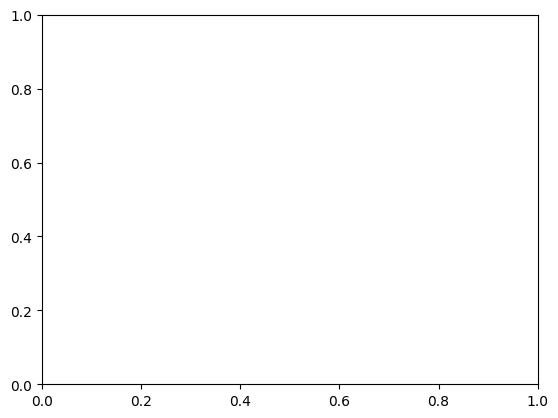

In [89]:
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train_features.T,y_train_norm )
# Make predictions using the testing set
y_pred = regr.predict(X_test_features.T)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
        % mean_squared_error(y_test_norm, y_pred))
# Explained variance score: 1 is perfect prediction 
print('Variance score: %.2f' % r2_score(y_test_norm, y_pred))
# Plot outputs
plt.scatter(X_test_features.T, y_test_norm,  color='black')
plt.plot(X_test_features, y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


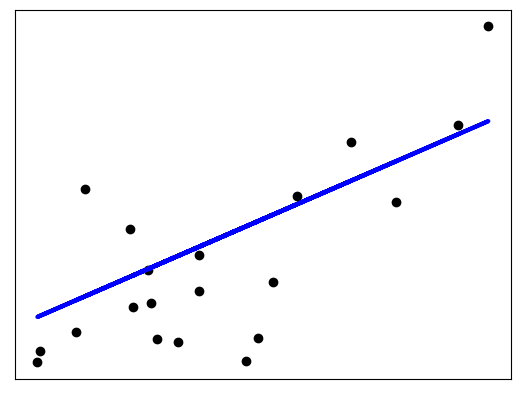

In [32]:
# Import a dataset  from sklearn
from matplotlib import pyplot as plt
#import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import datasets
# import r2_score from sklearn
from sklearn.metrics import r2_score
# Load the diabetes dataset
diabetes = datasets.load_diabetes()
# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]
# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)
# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
        % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction 
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))
# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()


In [33]:
# use lazypredict to predict the model
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
# fit all models
reg = LazyRegressor(predictions=True)
regresion_models, regresion_predictions = reg.fit(diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test) 
regresion_models



100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
PassiveAggressiveRegressor,0.51,0.54,47.22,0.01
RANSACRegressor,0.50,0.52,47.96,0.06
PoissonRegressor,0.47,0.50,49.11,0.13
HuberRegressor,0.47,0.50,49.33,0.01
LarsCV,0.44,0.47,50.48,0.01
OrthogonalMatchingPursuit,0.44,0.47,50.48,0.01
LinearRegression,0.44,0.47,50.48,0.01
LassoLarsIC,0.44,0.47,50.48,0.01
LassoLarsCV,0.44,0.47,50.48,0.02


In [34]:
diabetes_X_train.shape

(422, 1)

In [35]:
diabetes_X_train

array([[ 0.06169621],
       [-0.05147406],
       [ 0.04445121],
       [-0.01159501],
       [-0.03638469],
       [-0.04069594],
       [-0.04716281],
       [-0.00189471],
       [ 0.06169621],
       [ 0.03906215],
       [-0.08380842],
       [ 0.01750591],
       [-0.02884001],
       [-0.00189471],
       [-0.02560657],
       [-0.01806189],
       [ 0.04229559],
       [ 0.01211685],
       [-0.0105172 ],
       [-0.01806189],
       [-0.05686312],
       [-0.02237314],
       [-0.00405033],
       [ 0.06061839],
       [ 0.03582872],
       [-0.01267283],
       [-0.07734155],
       [ 0.05954058],
       [-0.02129532],
       [-0.00620595],
       [ 0.04445121],
       [-0.06548562],
       [ 0.12528712],
       [-0.05039625],
       [-0.06332999],
       [-0.03099563],
       [ 0.02289497],
       [ 0.01103904],
       [ 0.07139652],
       [ 0.01427248],
       [-0.00836158],
       [-0.06764124],
       [-0.0105172 ],
       [-0.02345095],
       [ 0.06816308],
       [-0